In [ ]:
  import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
from bertopic import BERTopic
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import ast

nltk.download('punkt')
nltk.download('stopwords')

/usr/local/lib/python3.11/dist-packages/hdbscan/plots.py:448: DeprecationWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.11/dist-packages/hdbscan/robust_single_linkage_.py:154: DeprecationWarning: invalid escape sequence '\{'
  """Perform robust single linkage clustering from a vector array
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Load Dataset
df = pd.read_csv("negative_comments.csv")
df.head()

,Timestamp,Comment,Tokenized_Comment,BERTweet_Sentiment
0,2024-10-22 22:39:00,update e coli outbreak linked to mcdonalds qua...,update e coli outbreak linked quarter pounder ...,Negative
1,2024-10-23 02:47:00,i just had it 3 hrs ago in northeast in app i ...,3 hr ago northeast app see now stopped selling...,Negative
2,2024-10-22 23:31:00,so many food outbreaks lately,many outbreak lately,Negative
3,2024-10-23 06:42:00,im from colorado and i heard about this on the...,colorado heard news very sad very scary,Negative
4,2024-10-24 22:35:00,stores in austin texas have all removed from t...,store austin texas all removed menu tx,Negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Timestamp           1566 non-null   object
 1   Comment             1566 non-null   object
 2   Tokenized_Comment   1566 non-null   object
 3   BERTweet_Sentiment  1566 non-null   object
dtypes: object(4)
memory usage: 49.1+ KB


#Before

In [ ]:
# ==============================
# Train LDA on Tweet Data
# ==============================

def safe_literal_eval(val):
    """Safely converts a string representation of a list into an actual list."""
    try:
        return ast.literal_eval(val) if isinstance(val, str) and val.startswith("[") else val
    except (SyntaxError, ValueError):
        return val

df['tokens'] = df['Tokenized_Comment'].apply(safe_literal_eval)

df['tokens'] = df['Tokenized_Comment'].apply(lambda x: x if isinstance(x, list) else str(x).split())

# Create Dictionary and Corpus for LDA
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=20,
    random_state=42,
    passes=15,
    iterations=500,
    alpha='auto',
    eta='auto',
    minimum_probability=0.01
)


print("\n=== LDA Topics ===")
for topic_id, words in lda_model.show_topics(num_topics=20, num_words=10, formatted=False):
    print(f"Topic {topic_id}: {[word for word, _ in words]}")


# ==============================
# Train BERTopic on Tweet Data
# ==============================
df['Tokenized_Comment'] = df['Tokenized_Comment'].astype(str)

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(df['Tokenized_Comment'])

bertopic_topics = topic_model.get_topics()
num_bertopic_topics = len(bertopic_topics)

print(f"\n=== BERTopic: {num_bertopic_topics} Topics Found ===")
for topic_id, words in bertopic_topics.items():
    print(f"Topic {topic_id}: {[word for word, _ in words[:10]]}")


=== LDA Topics ===
Topic 0: ['but', 'fry', 'year', 'go', 'sandwich', 'get', 'you', 'chicken', 'no', 'back']
Topic 1: ['but', 'get', 'sandwich', 'were', 'tried', 'no', 'up', 'now', 'all', 'off']
Topic 2: ['more', 'want', 'but', 'expensive', 'year', 'change', 'ago', 'price', 'than', 'or']
Topic 3: ['but', 'price', 'good', 'no', 'sauce', 'way', 'people', 'ha', 'new', 'dollar']
Topic 4: ['back', 'all', 'you', 'no', 'but', 'only', 'get', 'ice', 'cream', 'more']
Topic 5: ['never', 'fry', 'find', 'cant', 'were', 'than', 'here', 'all', 'get', 'or']
Topic 6: ['you', 'sauce', 'all', 'but', 'now', 'deal', 'right', 'taste', 'no', 'pay']
Topic 7: ['but', 'deal', 'get', 'no', 'year', 'app', 'more', 'now', 'any', '5']
Topic 8: ['price', 'no', 'oh', 'you', 'get', 'or', 'only', 'think', 'people', 'more']
Topic 9: ['but', 'all', 'people', 'no', 'staged', 'sauce', 'big', 'point', 'other', 'chicken']
Topic 10: ['but', 'get', 'still', 'can', 'price', 'up', 'pickle', 'bad', 'down', 'off']
Topic 11: ['now',

In [ ]:
ber_topic_tokens = [[word for word, _ in topic[:10]] for topic in bertopic_topics.values()]

ber_topic_tokens = [topic for topic in ber_topic_tokens if topic]

ber_topic_token_ids = [[dictionary.token2id.get(word, -1) for word in topic] for topic in ber_topic_tokens]

ber_topic_token_ids = [[token_id for token_id in topic if token_id != -1] for topic in ber_topic_token_ids]

ber_topic_token_ids = [topic for topic in ber_topic_token_ids if topic]

# LDA COherence
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()

# BERTopic Coherence
coherence_model_bertopic = CoherenceModel(
    topics=ber_topic_token_ids, texts=df['tokens'], dictionary=dictionary, coherence='c_v'
)
coherence_bertopic = coherence_model_bertopic.get_coherence()

print(f"LDA Coherence Score: {coherence_lda:.3f}")
print(f"BERTopic Coherence Score: {coherence_bertopic:.3f}")

LDA Coherence Score: 0.411
BERTopic Coherence Score: 0.427


In [ ]:
# LDA diversity
def calculate_lda_topic_diversity(lda_model, top_n_words=10):
    topics = lda_model.show_topics(num_topics=lda_model.num_topics, num_words=top_n_words, formatted=False)
    unique_words = set()
    for topic in topics:
        unique_words.update([word for word, _ in topic[1]])
    return len(unique_words) / (top_n_words * lda_model.num_topics)

lda_topic_diversity = calculate_lda_topic_diversity(lda_model)

# BERTopic diversity
def calculate_topic_diversity(model, top_n_words=10):
    words = model.get_topics()
    unique_words = set()
    for topic in words.values():
        unique_words.update([word for word, _ in topic[:top_n_words]])
    return len(unique_words) / (top_n_words * len(words))

bertopic_topic_diversity = calculate_topic_diversity(topic_model)

print(f"LDA Topic Diversity Score: {lda_topic_diversity:.3f}")
print(f"BERTopic Topic Diversity Score: {bertopic_topic_diversity:.3f}")

LDA Topic Diversity Score: 0.420
BERTopic Topic Diversity Score: 0.844


#Find Optimal Topics For LDA

Num Topics: 2, Coherence Score: 0.5036
Num Topics: 3, Coherence Score: 0.4778
Num Topics: 4, Coherence Score: 0.4928
Num Topics: 5, Coherence Score: 0.4768
Num Topics: 6, Coherence Score: 0.4753
Num Topics: 7, Coherence Score: 0.4596
Num Topics: 8, Coherence Score: 0.4725
Num Topics: 9, Coherence Score: 0.4537
Num Topics: 10, Coherence Score: 0.4501
Num Topics: 11, Coherence Score: 0.4333
Num Topics: 12, Coherence Score: 0.4380
Num Topics: 13, Coherence Score: 0.4472
Num Topics: 14, Coherence Score: 0.4479
Num Topics: 15, Coherence Score: 0.4365
Num Topics: 16, Coherence Score: 0.4163
Num Topics: 17, Coherence Score: 0.4002
Num Topics: 18, Coherence Score: 0.4157
Num Topics: 19, Coherence Score: 0.4065


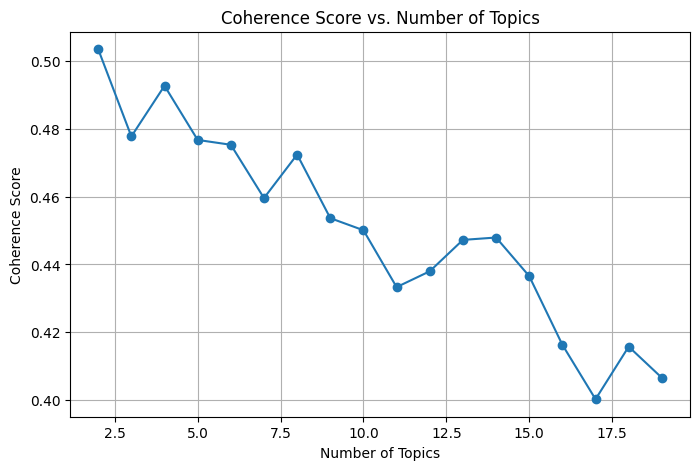

Optimal Number of Topics: 2


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, topic_range):
    coherence_scores = []
    for num_topics in topic_range:
        lda_model = gensim.models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            iterations=200
        )
        coherence_model = CoherenceModel(
            model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        print(f"Num Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")

    return coherence_scores


topic_range = range(2, 20)

coherence_scores = compute_coherence_values(dictionary, corpus, df['tokens'], topic_range)

plt.figure(figsize=(8, 5))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.grid()
plt.show()

optimal_topic_num = topic_range[coherence_scores.index(max(coherence_scores))]
print(f"Optimal Number of Topics: {optimal_topic_num}")


#Find Optimal Topics Of BERTopic

Num Topics: 2, Coherence Score: 0.5036
Num Topics: 3, Coherence Score: 0.4778
Num Topics: 4, Coherence Score: 0.4928
Num Topics: 5, Coherence Score: 0.4768
Num Topics: 6, Coherence Score: 0.4753
Num Topics: 7, Coherence Score: 0.4596
Num Topics: 8, Coherence Score: 0.4725
Num Topics: 9, Coherence Score: 0.4537
Num Topics: 10, Coherence Score: 0.4501
Num Topics: 11, Coherence Score: 0.4333
Num Topics: 12, Coherence Score: 0.4380
Num Topics: 13, Coherence Score: 0.4472
Num Topics: 14, Coherence Score: 0.4479
Num Topics: 15, Coherence Score: 0.4365
Num Topics: 16, Coherence Score: 0.4163
Num Topics: 17, Coherence Score: 0.4002
Num Topics: 18, Coherence Score: 0.4157
Num Topics: 19, Coherence Score: 0.4065


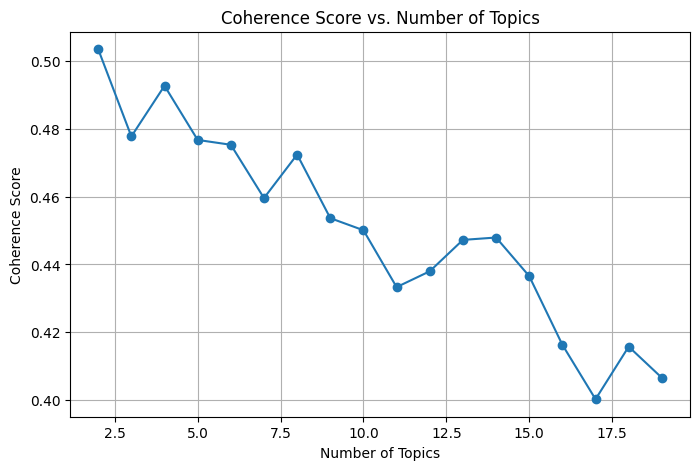


Optimal Number of BERTTopics: 2


In [ ]:
def compute_coherence_values_bertopic(texts, topic_range):
    coherence_scores = []
    vectorizer_model = None
    for num_topics in topic_range:
        topic_model = BERTopic(top_n_words=10, nr_topics=num_topics)
        topics, _ = topic_model.fit_transform(texts)

        topic_words = [list(zip(*topic_model.get_topic(topic)[1]))[0] for topic in range(len(topic_model.get_topics())) if topic != -1]

        dictionary = Dictionary(texts)
        corpus = [dictionary.doc2bow(text) for text in texts]

        coherence_model = CoherenceModel(
            topics=topic_words,
            texts=texts,
            corpus=corpus,
            dictionary=dictionary,
            coherence='c_v'
        )

        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        print(f"Num Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")

    return coherence_scores

topic_range = range(2, 20)
coherence_scores = compute_coherence_values(dictionary, corpus, df['tokens'], topic_range)

plt.figure(figsize=(8, 5))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.grid()
plt.show()

# Dispay
optimal_topic_num = topic_range[coherence_scores.index(max(coherence_scores))]
print(f"\nOptimal Number of BERTTopics: {optimal_topic_num}")

#After

In [ ]:
# ==============================
# Train LDA on Tweet Data
# ==============================

def safe_literal_eval(val):
    """Safely converts a string representation of a list into an actual list."""
    try:
        return ast.literal_eval(val) if isinstance(val, str) and val.startswith("[") else val
    except (SyntaxError, ValueError):
        return val

df['tokens'] = df['Tokenized_Comment'].apply(safe_literal_eval)

df['tokens'] = df['Tokenized_Comment'].apply(lambda x: x if isinstance(x, list) else str(x).split())

dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=2,
    random_state=42,
    passes=15,
    iterations=500,
    alpha='auto',
    eta='auto',
    minimum_probability=0.01
)

print("\n=== LDA: 2 Optimal Topics Found ===")
for topic_id, words in lda_model.show_topics(num_topics=20, num_words=10, formatted=False):
    print(f"Topic {topic_id}: {[word for word, _ in words]}")


# ==============================
# Train BERTopic on Tweet Data
# ==============================
df['Tokenized_Comment'] = df['Tokenized_Comment'].astype(str)

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(df['Tokenized_Comment'])


bertopic_topics = topic_model.get_topics()
num_bertopic_topics = len(bertopic_topics)

# Display BERTopic results
print(f"\n=== BERTopic: {2} Optimal Topics Found ===")
for topic_id, words in list(bertopic_topics.items())[:3]:  # Show only first 3
    print(f"Topic {topic_id}: {[word for word, _ in words[:10]]}")


=== LDA: 2 Optimal Topics Found ===
Topic 0: ['you', 'no', 'get', 'but', 'price', 'fry', 'or', 'all', 'only', 'deal']
Topic 1: ['but', 'all', 'people', 'or', 'get', 'you', 'were', 'up', 'sauce', 'now']

=== BERTopic: 2 Optimal Topics Found ===
Topic -1: ['but', 'no', 'big', 'or', 'you', 'only', 'mcds', 'people', 'get', 'mac']
Topic 0: ['no', 'you', 'gross', 'disgusting', 'never', 'joke', 'lying', 'minute', 'always', 'sign']
Topic 1: ['app', 'deal', 'out', 'day', 'get', 'no', 'sold', 'only', 'use', 'available']
